# 2. (Deep) CNNs for Image Colorization

## This experiment is to check a Large K and its' importance in the Model.

### K-Means Clustering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import warnings; warnings.simplefilter('ignore')
import numpy as np
import random
import os

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [4]:
def extract_images():
    folder = 'cifar-10-batches-py'
    
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3',
            'data_batch_4', 'data_batch_5', 'test_batch']
    
    X = []
    for each in files:
        images = unpickle(os.path.join(folder, each))
        all_img = images[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
        
        for i in range(len(all_img)):
            if(images[b'labels'][i] == 2):
                X.append(all_img[i])
    
    return X

In [5]:
img_list = extract_images()
len(img_list)

6000

In [ ]:
plt.imshow(img_list[20])

In [7]:
for j in range(len(img_list)):
    each = img_list[j]
    each = each / 255.0
    if(j == 0):
        dataa = each.reshape(32*32, 3)
    else:
        dataa = np.append(dataa, each.reshape(32*32, 3), axis=0)

In [8]:
print(dataa.shape)
extract = np.random.randint(low=0, high=6144000, size=1843200) #30% of Data points
data = [dataa[each] for each in extract]
data = np.array(data)

(6144000, 3)


In [9]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

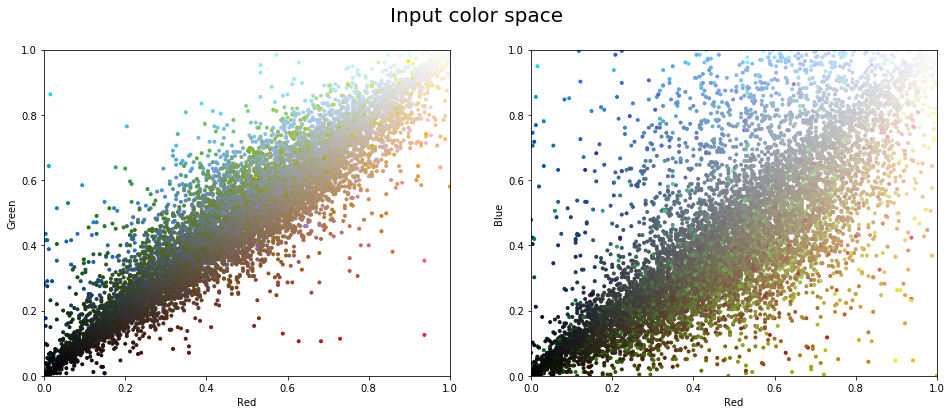

In [10]:
plot_pixels(data, title='Input color space')

In [11]:
kmeans = KMeans(10)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

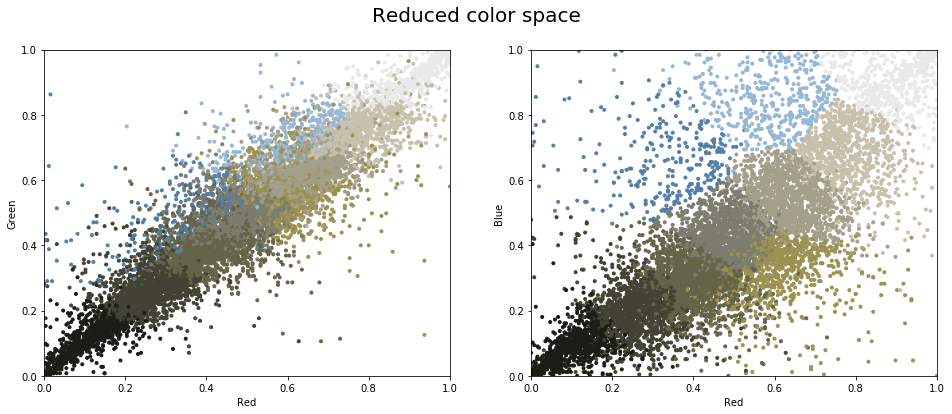

In [13]:
plot_pixels(data, colors=new_colors, title='Reduced color space')

Text(0.5,1,'10-color Image')

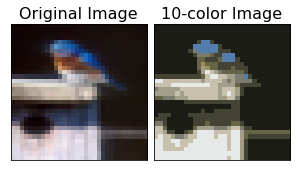

In [14]:
img = img_list[1]
img = img / 255.
dataa = img.reshape(32*32, 3)
new_colorss = kmeans.cluster_centers_[kmeans.predict(dataa)]

recolored = new_colorss.reshape(32, 32, 3)

fig, ax = plt.subplots(1, 2, figsize=(5, 5),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(recolored)
ax[1].set_title('10-color Image', size=16)

In [15]:
#Saving Model
import pickle
# now you can save it to a file
with open('KMeans_Model10.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# and later you can load it
#with open('KMeans_Model.pkl', 'rb') as f:
#    kmeans = pickle.load(f)

In [16]:
predicted = kmeans.predict(data)

In [17]:
set(predicted)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Convolutional Neural networks

In [18]:
import skimage
from skimage import io
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

In [19]:
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

Using TensorFlow backend.


In [20]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
K.set_image_dim_ordering('tf')

In [21]:
#Method to get the Train and Test dataset
def train_test():
    folder = 'cifar-10-batches-py'
    
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3',
            'data_batch_4', 'data_batch_5', 'test_batch']
    
    x_train_img_list = []
    y_train_img_list = []
    for each in files:
        images = unpickle(os.path.join(folder, each))
        all_img = images[b'data'].reshape(10000, 32, 32, 3).astype('uint8') #.transpose(0, 2, 3, 1).astype('uint8')
        
        for i in range(len(all_img)):
            if(images[b'labels'][i] == 2):
                im = all_img[i] / 255.
                #nn = np.resize(im, (32, 32, 1))
                nn = np.resize(im, (32, 32, 1))
                x_train_img_list.append(nn)
                y_train_img_list.append(kmeans.predict(im.reshape(32*32, 3)))
    
    return x_train_img_list, y_train_img_list

In [22]:
x_train, y_train = train_test()

In [23]:
x = np.array(x_train)
y = np.array(y_train)
x.shape, y.shape

((6000, 32, 32, 1), (6000, 1024))

In [24]:
img_rows = 32
img_cols = 32
num_channels = 1
num_epochs = 30
batch_size = 320

save_folder = 'CNNModel'

num_classes = 10

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5)
X_train = x[:-1000]
y_train = y[:-1000]
X_test = x[-1000:]
y_test = y[-1000:]

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [26]:
y_train = y_train.reshape((5000, 32*32*10))
y_test = y_test.reshape((1000, 32*32*10))

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 32, 32, 1), (5000, 10240), (1000, 32, 32, 1), (1000, 10240))

In [28]:
input_shape = X_train[0].shape
print(input_shape)

(32, 32, 1)


In [29]:
#Dictionary of New colors, i.e. the real color code of the 4 Clusters
dic = {}
for i in range(len(new_colors)):
    dic[predicted[i]] = new_colors[i]
print(dic)

{0: array([0.25896321, 0.263803  , 0.20349732]), 1: array([0.78219949, 0.75429166, 0.67564017]), 2: array([0.39950585, 0.39265803, 0.28112852]), 3: array([0.10977249, 0.11277123, 0.08960464]), 4: array([0.64031205, 0.62300056, 0.54135656]), 5: array([0.32742011, 0.49228868, 0.66789847]), 6: array([0.60790883, 0.56818933, 0.31825312]), 7: array([0.48622629, 0.48585857, 0.43350367]), 8: array([0.58930238, 0.71733952, 0.84633358]), 9: array([0.90770009, 0.91699454, 0.91217193])}


In [ ]:
#CNN Model
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (4, 4), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (5, 5), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (2, 2), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(17200))
model.add(Activation('relu'))
model.add(Dense(16383))
model.add(Activation('relu'))
model.add(Dense(10240))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=2e-4), metrics=['acc'])

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
__________

In [ ]:
model.save('ModelCNN10.h5')

### Plotting Plots

In [ ]:
# visualizing losses and accuracy for Train and Validation Sets
train_acc=hist.history['acc']
train_loss=hist.history['loss']
xc=range(num_epochs)

plt.figure(figsize=(4,4))
plt.plot(xc,train_acc)
plt.plot(xc,train_loss)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('Train Acc and Loss')
plt.grid(True)
plt.legend(['Accuracy','Loss'])

In [ ]:
#Test Accuracy and Loss
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#Visual Comparision between Original and new images
for p in range(10):
    img1 = img_list[p]
    img = img1 / 255.
    img = np.resize(img, (1, 32, 32, 1))
    data = img.reshape(1, 32, 32, 1)
    new_cols = model.predict(img)

    recolored = new_cols.reshape(32, 32, 10)

    new_cols = new_cols.reshape(32, 32, 10)
    val = []
    for i in range(32):
        for j in range(32):
            val.append(dic[np.argmax(new_cols[i][j])])
    recolored = np.array(val).reshape(32, 32, 3)

    fig, ax = plt.subplots(1, 2, figsize=(5, 5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(wspace=0.05)
    ax[0].imshow(img1)
    ax[0].set_title('Original Image', size=16)
    ax[1].imshow(recolored)
    ax[1].set_title('10-color Image', size=16)

**End of Submission-7 Notebook.**